## This notebook is for implementing a prediction method for hotel bookings.
The implementation takes notes from:
1. Webb, T., Schwartz, Z., Xiang, Z. and Singal, M., 2020. Revenue management forecasting: the resiliency of advanced booking methods given dynamic booking windows. International Journal of Hospitality Management, 89, p.102590.
2. Zhang, Y., 2019. Forecasting hotel demand using machine learning approaches (Doctoral dissertation, Cornell University).

The data is originally from Antonio, N., de Almeida, A. and Nunes, L., 2019. Hotel booking demand datasets. Data in brief, 22, pp.41-49.   
More detailed explanation for the variables can be seen there.


In [126]:
import numpy as np
import pandas as pd
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline

### Quick data exploration

In [8]:
data = pd.read_csv("../Data/hotel_bookings.csv")
data.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0


## Take only the relevant data for our use case.  
We take all the reservations, expect the ones that were canceled.
Then we'll only take the date with leadtimes <180, to reduce complexity of the models.

In [150]:
df = data.query('is_canceled == 0')[['lead_time','arrival_date_year','arrival_date_month','arrival_date_week_number','arrival_date_day_of_month']]
df["date"] = pd.to_datetime(df['arrival_date_day_of_month'].astype(str) +'-'+ df['arrival_date_month'].astype(str)+'-'+ df['arrival_date_year'].astype(str),infer_datetime_format=True)
df = df[['lead_time','date']]
df = df.groupby(['date','lead_time',]).size().reset_index().pivot(index="date", columns="lead_time").fillna(0)
df=df.droplevel(0, axis=1).iloc[:, ::-1].cumsum(axis=1).iloc[:, ::-1].reset_index().iloc[:,:182]
df = df.rename(columns={col: 'ROH_'+str(col) 
                        for col in df.columns if col not in ['date']})
df['weekday'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month_name()
df['year'] = df['date'].dt.year
df

lead_time,date,ROH_0,ROH_1,ROH_2,ROH_3,ROH_4,ROH_5,ROH_6,ROH_7,ROH_8,...,ROH_174,ROH_175,ROH_176,ROH_177,ROH_178,ROH_179,ROH_180,weekday,month,year
0,2015-07-01,103.0,101.0,100.0,99.0,99.0,98.0,98.0,97.0,95.0,...,67.0,67.0,67.0,67.0,67.0,67.0,67.0,Wednesday,July,2015
1,2015-07-02,36.0,33.0,31.0,31.0,29.0,29.0,28.0,28.0,28.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Thursday,July,2015
2,2015-07-03,37.0,37.0,36.0,34.0,32.0,31.0,31.0,31.0,31.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,Friday,July,2015
3,2015-07-04,45.0,44.0,43.0,42.0,42.0,41.0,41.0,41.0,41.0,...,11.0,11.0,11.0,11.0,11.0,11.0,11.0,Saturday,July,2015
4,2015-07-05,37.0,35.0,35.0,32.0,32.0,32.0,32.0,32.0,32.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,Sunday,July,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,2017-08-27,125.0,113.0,106.0,106.0,102.0,101.0,101.0,98.0,98.0,...,29.0,29.0,28.0,28.0,27.0,26.0,26.0,Sunday,August,2017
789,2017-08-28,147.0,142.0,141.0,140.0,138.0,137.0,136.0,135.0,135.0,...,83.0,83.0,83.0,83.0,83.0,83.0,83.0,Monday,August,2017
790,2017-08-29,81.0,73.0,70.0,70.0,70.0,69.0,67.0,64.0,64.0,...,25.0,25.0,25.0,25.0,24.0,23.0,23.0,Tuesday,August,2017
791,2017-08-30,62.0,57.0,57.0,57.0,56.0,55.0,54.0,54.0,52.0,...,11.0,11.0,11.0,11.0,11.0,11.0,11.0,Wednesday,August,2017


In [151]:
df.describe()

lead_time,ROH_0,ROH_1,ROH_2,ROH_3,ROH_4,ROH_5,ROH_6,ROH_7,ROH_8,ROH_9,...,ROH_172,ROH_173,ROH_174,ROH_175,ROH_176,ROH_177,ROH_178,ROH_179,ROH_180,year
count,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,...,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000
mean,94.786885,87.327869,83.369483,81.029004,78.968474,77.027743,75.313997,73.746532,72.284994,71.131148,...,14.823455,14.643127,14.496847,14.324086,14.163934,14.040353,13.871375,13.731400,13.586381,2016.074401
std,34.474866,34.678916,34.735813,34.714207,34.385519,34.292992,34.278435,34.344659,34.096150,34.010106,...,21.157875,21.026739,20.961612,20.853254,20.764939,20.697640,20.646889,20.550989,20.471967,0.730479
min,15.000000,13.000000,13.000000,12.000000,11.000000,10.000000,9.000000,8.000000,7.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000
25%,70.000000,62.000000,58.000000,56.000000,53.000000,51.000000,50.000000,48.000000,46.000000,45.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2016.000000
50%,93.000000,87.000000,83.000000,80.000000,79.000000,77.000000,76.000000,75.000000,73.000000,72.000000,...,6.000000,6.000000,6.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2016.000000
75%,117.000000,109.000000,105.000000,103.000000,100.000000,98.000000,97.000000,95.000000,94.000000,92.000000,...,22.000000,22.000000,21.000000,21.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2017.000000
max,255.000000,244.000000,235.000000,226.000000,221.000000,215.000000,214.000000,214.000000,213.000000,212.000000,...,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,2017.000000


## Now we have the data as we want it

<AxesSubplot:xlabel='date', ylabel='ROH_0'>

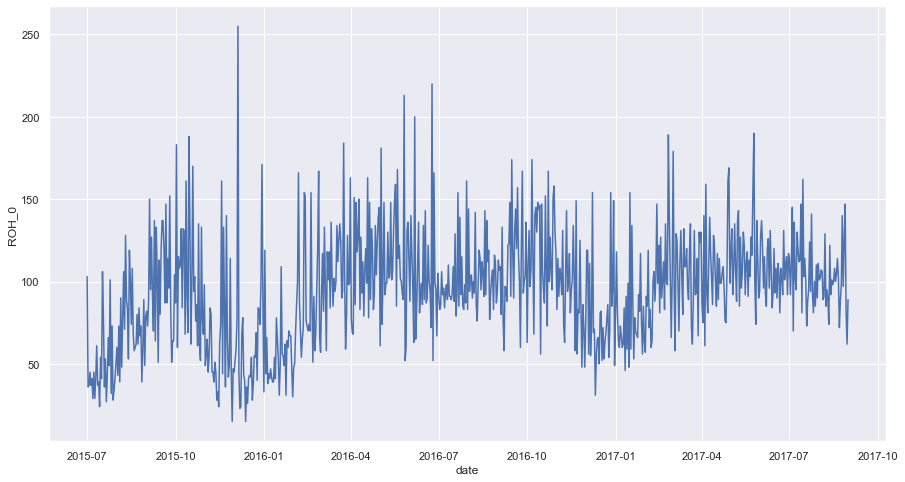

In [152]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=df,x='date',y='ROH_0')

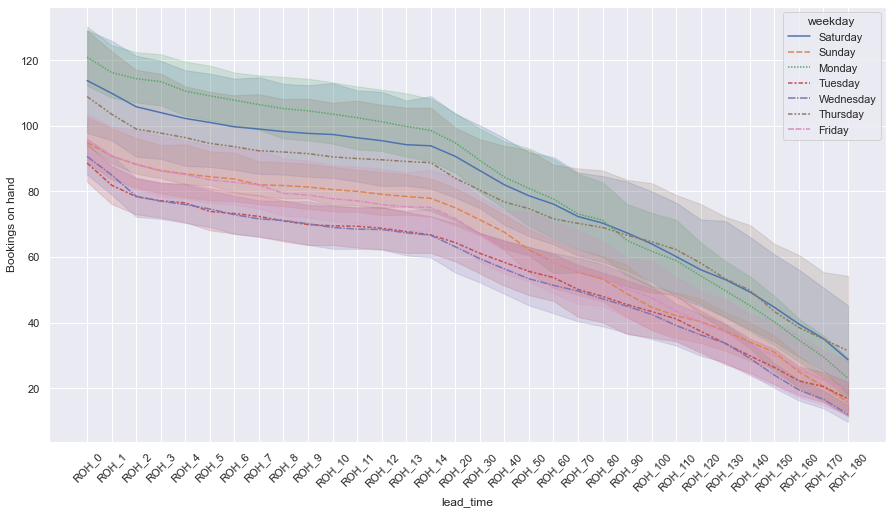

In [304]:
sns.set(rc = {'figure.figsize':(15,8)})
example_booking_curve = df[(df['date']>'2016-07-01') & (df['date']<'2016-08-30')].drop(columns=['date','month','year'])
# example_booking_curve
example_booking_curve=example_booking_curve.T
example_booking_curve.columns = example_booking_curve.iloc[181,:]
sns.lineplot(data=example_booking_curve[0:15].append(example_booking_curve[20::10]))
plt.ylabel('Bookings on hand')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);


There is a significant difference in the booking curves between weekdays, but even within them.   
Weekends have higher ROH throughout the lead times.

## Next we'll implement XGBoost model
This will take care of the missing values as we predict further into the future.
Later, we can implement xgboost for the booking curves, and a naive time series prediction for just the final bookings.   
These can the be combined using weighted average.   
For xgboost, we can test if we can add simulated samples with missing values, to imitate the future that is unknown.

In [ ]:
# Duplicate data
# Add some jitter (+-5 for random ROH_n per line)
# randomly assign nan for different ROH_n = simulate missising future values -> Can xgboost learn from this?
# Implement, fit and optimize xgboost for the data
# Validate

# Target = final ROH_0
# Features = booking curves with some values until ROH_0 NaN + date information



